# Semantic Segmentation

--- Alessandro Motta, 2nd of November 2023

In [43]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers, models, Model

In [5]:
# Get the data
!curl -L https://github.com/michelucci/HSLU-CASML2-Deep_Learning/raw/semantic-segmentation/COMPUTER-VISION/datasets/m2nist.zip -o /tmp/m2nist.zip
!unzip /tmp/m2nist.zip -d /tmp/m2nist

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 12.2M  100 12.2M    0     0  30.4M      0 --:--:-- --:--:-- --:--:-- 30.4M
Archive:  /tmp/m2nist.zip
  inflating: /tmp/m2nist/combined.npy  
  inflating: /tmp/m2nist/segmented.npy  


## Load and Inspect Data

In [54]:
images = np.load('/tmp/m2nist/combined.npy')
segmentations = np.load('/tmp/m2nist/segmented.npy')

images = images.astype(dtype=np.float32) / 255 # from 0-255 to 0-1
segmentations = segmentations.astype(dtype=np.float32) # 0, 1

# TODO(amotta): Split into training and test set
# TODO(amotta): Downsample?

In [55]:
images.shape
segmentations.shape

(5000, 64, 84, 11)

## Build U-Net-like Model

In [119]:
def build_down(input, num_features):
  x = input
  outputs = []
  for level, features in enumerate(num_features):
    if level > 0:
      x = layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(x)
    x = layers.Conv2D(features, (5, 5), strides = (1, 1), activation = 'relu', padding='same')(x)
    x = layers.BatchNormalization(axis = 3)(x)
    outputs.append(x)
  return outputs

def build_up(down, num_outputs):
  x = down[-1]
  for level, skip in reversed(list(enumerate(down[:-1]))):
    x = layers.UpSampling2D(size = (2, 2), interpolation = 'nearest')(x)
    x = layers.Concatenate(axis = 3)([x, skip])

    if level > 0:
      x = layers.Conv2D(skip.shape[-1], (5, 5), strides = (1, 1), activation = 'relu', padding = 'same')(x)
      x = layers.BatchNormalization(axis = 3)(x)
    else:
      x = layers.Conv2D(num_outputs, (1, 1), activation = 'sigmoid')(x)

  return x

def build_model(input_shape, num_features, num_outputs):
  input = layers.Input(shape=input_shape)
  down = build_down(input, num_features)
  output = build_up(down, num_outputs)

  model = Model(inputs=input, outputs=output)
  model.compile(loss = 'binary_focal_crossentropy', optimizer = 'adam')
  return model

model = build_model([64, 84, 1], [12, 12, 12], 11)

In [120]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 64, 84, 1)]          0         []                            
                                                                                                  
 conv2d_129 (Conv2D)         (None, 64, 84, 12)           312       ['input_32[0][0]']            
                                                                                                  
 batch_normalization_69 (Ba  (None, 64, 84, 12)           48        ['conv2d_129[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_53 (MaxPooli  (None, 32, 42, 12)           0         ['batch_normalization_6

In [121]:
EPOCHS = 10
history = model.fit(
  images, segmentations,
  epochs = EPOCHS, verbose = 1,
  batch_size = 32)

Epoch 1/10
157/157 [==============================] - 85s 527ms/step - loss: 0.1254
Epoch 2/10
157/157 [==============================] - 85s 540ms/step - loss: 0.0223
Epoch 3/10
157/157 [==============================] - 84s 533ms/step - loss: 0.0084
Epoch 4/10
157/157 [==============================] - 83s 532ms/step - loss: 0.0056
Epoch 5/10
157/157 [==============================] - 83s 529ms/step - loss: 0.0043
Epoch 6/10
157/157 [==============================] - 87s 552ms/step - loss: 0.0036
Epoch 7/10
157/157 [==============================] - 83s 526ms/step - loss: 0.0030
Epoch 8/10
157/157 [==============================] - 84s 535ms/step - loss: 0.0027
Epoch 9/10
157/157 [==============================] - 83s 531ms/step - loss: 0.0024
Epoch 10/10
157/157 [==============================] - 84s 538ms/step - loss: 0.0022


1/1 [==============================] - 0s 49ms/step


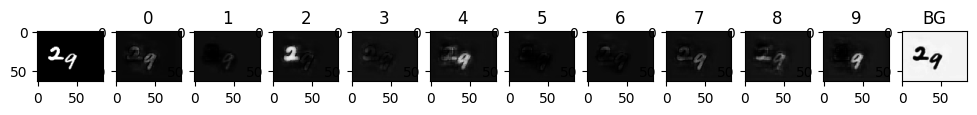

In [128]:
image = images[0]
preds = model.predict(np.expand_dims(image, axis=0))[0]
preds = np.split(preds, preds.shape[-1], axis=preds.ndim-1)

plt.figure(figsize=(12, 3))
plt.subplot(1, 12, 1)
plt.imshow(image, cmap='gray')

for i, pred in enumerate(preds):
  plt.subplot(1, 12, 2+i)

  plt.title(str(i) if i < 10 else "BG")
  plt.imshow(pred, cmap='gray', vmin=0, vmax=1)

plt.show()